## Create custom Plots from your dataset
The intend of this markdown is to provide you with the tools you need to visualize your data by selecting in a custom fassion the plots you want to create and the relationships you want to visualize.

### Table of Contents
- [First Steps](#first-steps)
    - [Import your Data](#import-your-data)
    - [Examine and Clean your Data](#clean-your-data)
- [Create Qualitative Plots](#create-qualitative-plots)
- [Create Quantitative Plots](#create-quantitative-plots)
    - [Create a Scatterplot Matrix to visualize the all realtionships in your data](#create-a-scatterplot-matrix-to-visualize-the-all-realtionships-in-your-data)
- [Plotly Interface](#plotly-interface)

# First Steps


### Import your Data

In [2]:
from matplotlib import image
import seaborn as sns
import pandas as pd
import rospkg
import os
import numpy as np
import matplotlib.pyplot as plt

- read in the data

In [3]:
path = rospkg.RosPack().get_path('arena-evaluation') + '/02_evaluation'
data = pd.read_feather(path+'/data.ftr')
# data_3d = pd.read_feather(path+'/data_3d.ftr')

- select the relevant rows and columns

In [4]:
data.dtypes

index         int64
Planner    category
Robot      category
World      category
Dyn_obs    category
             ...   
27           object
28           object
29           object
30           object
30.0         object
Length: 84, dtype: object

In [6]:
data['category'] = 'None'
data.loc[data.vel.notnull(),['category']] = 'var'
data.loc[data.path_length.notnull(),['category']] = 'med'
data = data.loc[data.category == 'med',:]
data_quali = data.iloc[:,1:18]
data_quali['dim'] = '3d'
data = data.iloc[0:24,:]
# data = data.sort_values(by=['Collision'],  ascending=True)

- datatypes

When visualizing the data (and to reduce the overall size of the file), it is advisable to convert the data type of the columns to a suitable data type. Some example codelines can be found below:

In [9]:
data.Robot = data.Robot.astype('string')
data.Robot = data.Robot.replace({'turtlebot3_burger': 'burger'})
data.Robot = data.Robot.astype('category')
data.done_reason = data.done_reason.astype('category')
# data.dim = data.dim.astype('category')
data.done_reason = data.done_reason.astype("category")
data.success = data.success.astype('int8')
data = data[data.time<190]
# data = data.loc[~((data.Planner =='rosnav') & (data.Robot == 'youbot'))]

- visualize your data

The following tool provides you with a gui interface for working with pandas df, allowing you to view your data and convert created graphics into python or html

In [ ]:
import plotly.express as px
from pandasgui import show

show(data)

### Examine and Clean your Data
when working with the robotics simulation it is vital to clean and check your data before visualizing it, since it is not unlikely that your simulation data migh be defective. Check for the following anomalies:

- outliers

Wrong values in your dataset can, if not detected, seriously impact the evaluation accuracy. 
There are a number of different ways to check your data for outliers. As these must be choosen on a case by case basis, we provide here only a helpful selection.


In [ ]:
# visualize your data
pd.plotting.scatter_matrix(data[1:max(data['episode'])],alpha=1., figsize=[15,15]);

In [12]:
# deselect outliers:
data = data.loc[data.jerk < .8]
data = data.loc[data.collision < 20]
data = data.loc[data.angle_over_length < 50]
data = data.loc[data.time < .8]

- equal number of elements in the dataset:

If you use this notebook to compare datasets, it is important that the datasets have the same length, as otherwise the quantitative measures can become defective. Make sure you have an equal amout of values of the combinations: `robot`+`planner`+`obs`+`world`

In [ ]:
# either import to an external tool:
# data.to_excel('data.xlsx')

# or check within the notebook:
# len(data.loc[data.dim == '2d'])

- Get a better understanding of your data with a scatter matrix
This will enable you to identify correlations and outliers

In [ ]:
vis_data = data.iloc[:10]
pd.plotting.scatter_matrix(vis_data, figsize=(20,20));

# Create Qualitative Plots
Qualitative plots visualize the paths, taken by the robot in the simulated world.

In [19]:
import yaml
import json
import glob
import scipy.ndimage as ndimage
import matplotlib.patches as patches

In [18]:
def get_qualitative_plots(self):
    os.mkdir(self.plot_dir + "/qualitative_plots")
    ### iteration part ###
    for map in self.maps:
        map_keys = []  # list of keys with current map
        map_path = self.maps_dict[map]
        with open(map_path+"/map.yaml") as file:  # get map file from map.yaml in map directory
            map_yaml = yaml.safe_load(file)
            map_file = map_yaml["image"]
            map_resolution = map_yaml["resolution"]
            map_origin = map_yaml["origin"]
        for key in self.keys:
            if self.data[key]["map"] == map:
                map_keys.append(key)  # append key if map matches current map
        for velocity in self.velocities:
            vel_keys = []  # list of keys with current velocity
            for key in map_keys:
                if self.data[key]["velocity"] == velocity:
                    # append key if velocity matches current velocity
                    vel_keys.append(key)
            for obstacle_number in self.obstacle_numbers:
                obs_keys = []  # list of keys with the current obstacle number
                for key in vel_keys:
                    if self.data[key]["obstacle_number"] == obstacle_number:
                        # append key if obstacle_number matches current obstacle_number
                        obs_keys.append(key)

                if len(obs_keys) == 0:
                    continue

                ### plotting part ###
                fig, ax = plt.subplots()

                # plot map image
                img = image.imread("{0}/{1}".format(map_path, map_file))
                # rotate by 90 degree to get rviz konvention
                img_rotated = ndimage.rotate(img, 90, reshape=True)
                plt.imshow(img_rotated, cmap="gray")

                # plot each planners path and if flag given collisions and zones
                for key in sorted(obs_keys):
                    # plot paths for every episode
                    planner = self.data[key]["planner"]
                    if planner in self.config["leave_out_planner"]:
                        continue
                    paths = self.data[key]["paths_travelled"]
                    episodes = paths.keys()
                    for i, episode in enumerate(episodes):
                        if i == 0:
                            if "3d" in planner:
                                plt.plot([], [],  # plot legend only with empty lines
                                         "--",
                                         label=self.config["labels"][planner],
                                         alpha=self.config["path_3D_alpha"],
                                         color=self.config["color_scheme"][planner],
                                         linewidth=2)
                            else:
                                plt.plot([], [],  # plot legend only with empty lines
                                         "-",
                                         label=self.config["labels"][planner],
                                         color=self.config["color_scheme"][planner],
                                         linewidth=2)

                        x, y = to_ros_coords(
                            paths[episode], img, map_resolution, map_origin)
                        # NOTE: sometimes episode is wrongly assigned _> skip first and last coordinates
                        x = x[3:-3]
                        y = y[3:-3]
                        if "3d" in planner:
                            plt.plot(x, y,
                                     "--",
                                     color=self.config["color_scheme"][planner],
                                     alpha=self.config["path_3D_alpha"],
                                     linewidth=self.config["path_size"]/map_resolution, zorder=1)
                        else:
                            plt.plot(x, y,
                                     "-",
                                     color=self.config["color_scheme"][planner],
                                     alpha=self.config["path_alpha"],
                                     linewidth=self.config["path_size"]/map_resolution, zorder=1)

                        if self.config["plot_progression"]:
                            x_progression = x[0::self.config["plot_progression_steps"]]
                            y_progression = y[0::self.config["plot_progression_steps"]]
                            plt.scatter(x_progression, y_progression,
                                        color=self.config["color_scheme"][planner],
                                        alpha=self.config["path_alpha"],
                                        s=self.config["plot_progression_size"]/map_resolution, zorder=1)

                    # plot collisions
                    if self.config["plot_collisions"]:
                        collisions = self.data[key]["collision_zones"]["collisions"]
                        if len(collisions) != 0:
                            x, y = to_ros_coords(
                                collisions, img, map_resolution, map_origin)
                            plt.scatter(x, y,
                                        color=self.config["color_scheme"][planner],
                                        alpha=self.config["collision_alpha"],
                                        s=self.config["collision_size"]/map_resolution, zorder=2)
                    # plot collision zones and centroids
                    if self.config["plot_collision_zones"]:
                        centroids = self.data[key]["collision_zones"]["centroids"]
                        if len(centroids) != 0:
                            counts = self.data[key]["collision_zones"]["counts"]
                            x, y = to_ros_coords(
                                centroids, img, map_resolution, map_origin)
                            plt.scatter(x, y,
                                        color=self.config["color_scheme"][planner],
                                        alpha=self.config["collision_alpha"],
                                        s=self.config["collision_size"]/map_resolution, zorder=2)
                            for i, centroid in enumerate(centroids):
                                # plot circle for collision zone
                                ax.add_patch(plt.Circle(tuple(to_ros_coords(centroid, img, map_resolution, map_origin)),
                                                        radius=self.config["collision_zone_base_diameter"] *
                                                        counts[i] /
                                                        map_resolution,
                                                        color=self.config["color_scheme"][planner],
                                                        fill=False, zorder=2))
                                # plot transparent circle as background of zone
                                ax.add_patch(plt.Circle(tuple(to_ros_coords(centroid, img, map_resolution, map_origin)),
                                                        radius=self.config["collision_zone_base_diameter"] *
                                                        counts[i] /
                                                        map_resolution,
                                                        color=self.config["color_scheme"][planner],
                                                        fill=True,
                                                        alpha=self.config["collision_zone_alpha"], zorder=2))

                # plot scenario properties (start, goal, dynamic obstacles)
                self.plot_scenario(obs_keys, img,  map_resolution, map_origin)

                # plot legend, title, axes labels
                if self.config["plot_qualitative_legend"]:
                    plt.legend(loc=self.config["plot_qualitative_legend_location"],
                               fontsize=self.config["plot_qualitative_legend_fontsize"])
                else:
                    plt.legend(loc=self.config["plot_qualitative_legend_location"],
                               fontsize=self.config["plot_qualitative_legend_fontsize"])
                    ax.get_legend().remove()
                if self.config["plot_qualitative_title"]:
                    if obstacle_number == "base_obstacle_number" and velocity == "base_velocity":
                        plt.title("Map: {0}".format(
                            map), fontsize=self.config["plot_qualitative_title_size"], fontweight="bold")
                    elif obstacle_number == "base_obstacle_number":
                        plt.title("Map: {0} Velocity: {1}.{2}".format(map, velocity.replace("vel", "")[0], velocity.replace(
                            "vel", "")[1]), fontsize=self.config["plot_qualitative_title_size"], fontweight="bold")
                    elif velocity == "base_velocity":
                        plt.title("Map: {0}\n Obstacles: {1}".format(map, int(obstacle_number.replace(
                            "obs", ""))), fontsize=self.config["plot_qualitative_title_size"], fontweight="bold")
                    else:
                        plt.title("Map: {0}\n Obstacles: {1} Velocity: {1}.{2} ".format(map, int(obstacle_number.replace("obs", "")), velocity.replace(
                            "vel", "")[0], velocity.replace("vel", "")[1]), fontsize=self.config["plot_qualitative_title_size"], fontweight="bold")
                if self.config["plot_qualitative_axes"]:
                    plt.xlabel(
                        "x in [m]", fontsize=self.config["plot_qualitative_axes_size"])
                    plt.ylabel(
                        "y in [m]", fontsize=self.config["plot_qualitative_axes_size"])
                    x_locs = ax.get_xticks()[1:-1]
                    y_locs = ax.get_yticks()[1:-1]
                    ax.set_xticks(x_locs)
                    ax.set_xticklabels([int(x*map_resolution) for x in x_locs])
                    ax.set_yticks(y_locs)
                    ax.set_yticklabels([int(y*map_resolution) for y in y_locs])
                    ax.tick_params(
                        axis='both', which='major', labelsize=self.config["plot_qualitative_axes_ticks_size"])
                else:
                    x_locs = ax.get_xticks()[1:-1]
                    y_locs = ax.get_yticks()[1:-1]
                    ax.set_xticks(x_locs)
                    ax.set_yticks(y_locs)
                    ax.set_xticklabels([])
                    ax.set_yticks(y_locs)
                    ax.set_yticklabels([])

                # plt.xlim(right=(100+100)/map_resolution)
                # plt.ylim(bottom=(100+100)/map_resolution)

                plt.savefig(self.plot_dir + "/qualitative_plots/qualitative_plot_{0}_{1}_{2}".format(
                    map, obstacle_number, velocity), bbox_inches='tight', dpi=200)
                fig.clear(True)
                plt.close()

def transform_waypoints(obstacle_paths, img, map_resolution, map_origin, ped_sim = False): # only necessary for old scenario.json
    transformed_paths = []
    if ped_sim:
        for path in obstacle_paths:
            transformed_paths.append([list(to_ros_coords(p,img, map_resolution, map_origin)) for p in path])
    else:
        for path in obstacle_paths:
            start = list(to_ros_coords(path[0],img, map_resolution, map_origin))
            waypoint = list(to_ros_coords((np.array(path[0]) + np.array(path[1])).tolist(),img, map_resolution, map_origin))
            transformed_paths.append([start,waypoint])
    return transformed_paths

def to_ros_coords(coords, img, map_resolution, map_origin):
    if type(coords) == tuple:
        return  [img.shape[0] - (y-map_origin[1])/map_resolution for x,y in coords],[img.shape[1] - (x-map_origin[0])/map_resolution for x,y in coords]
    elif type(coords) == list and (type(coords[0]) == float or type(coords[0]) == int):
        return  img.shape[0] - (coords[1]-map_origin[1])/map_resolution,img.shape[1] - (coords[0]-map_origin[0])/map_resolution
    elif type(coords) == list:
        return  [img.shape[0] - (point[1]-map_origin[1]) / map_resolution for point in coords],[img.shape[1] - (point[0]-map_origin[0]) / map_resolution for point in coords]

def plot_scenario(self, keys, img,  map_resolution, map_origin):
    scenario_dir = rospkg.RosPack().get_path('simulator_setup') + "/scenarios"
    scenario_dict = {x.split("/")[-1].replace(".json", "")                     : x for x in sorted(glob.glob("{0}/*.json".format(scenario_dir)))}
    # check if a map in /simulator_setup/maps fits scenario name
    for scene in sorted(scenario_dict.keys()):
        if scene in keys[0]:
            scenario_path = scenario_dict[scene]
    with open(scenario_path) as file:
        scenario = json.load(file)
    if "pedsim_agents" in scenario.keys():
        dynamic_obstacles = scenario["pedsim_agents"]
        obstacle_paths = [[obstacle["pos"]] + obstacle["waypoints"]
                          for obstacle in dynamic_obstacles]
        start_x, start_y = to_ros_coords(
            scenario["robot_position"], img, map_resolution, map_origin)
        goal_x, goal_y = to_ros_coords(
            scenario["robot_goal"], img, map_resolution, map_origin)
        obstacle_paths = transform_waypoints(
            obstacle_paths, img, map_resolution, map_origin, ped_sim=True)
    else:
        start = scenario["scenarios"][0]["robot"]["start_pos"]
        goal = scenario["scenarios"][0]["robot"]["goal_pos"]
        dynamic_obstacles = scenario["scenarios"][0]["dynamic_obstacles"]
        obstacle_paths = [[dynamic_obstacles[obstacle]["start_pos"][:-1]]+[waypoint[:-1]
                                                                           for waypoint in dynamic_obstacles[obstacle]["waypoints"]] for obstacle in dynamic_obstacles]
        start_x, start_y = to_ros_coords(
            start, img, map_resolution, map_origin)
        goal_x, goal_y = to_ros_coords(goal, img, map_resolution, map_origin)
        obstacle_paths = transform_waypoints(
            obstacle_paths, img, map_resolution, map_origin)

    # plot start point and goal
    # labels for legend only
    plt.scatter([], [], marker=self.config["start_marker"],
                label="Start", color=self.config["start_point_color"])
    plt.scatter([], [], marker=self.config["goal_marker"],
                label="Goal", color=self.config["goal_point_color"])
    # start and goal point
    plt.scatter(start_x, start_y, marker=self.config["start_marker"], s=self.config["start_size"] /
                map_resolution, color=self.config["start_point_color"], zorder=5)
    plt.scatter(goal_x, goal_y, marker=self.config["goal_marker"], s=self.config["goal_size"] /
                map_resolution, facecolors="none", edgecolors=self.config["goal_point_color"], zorder=5)

    # plot dynamic obstacle path
    for path in obstacle_paths:
        # plot waypoints as circles
        for i, waypoint in enumerate(path):
            plt.gca().add_patch(plt.Circle(waypoint,
                                           radius=self.config["obstacle_radius"] /
                                           map_resolution,
                                           color=self.config["obstacle_color"],
                                           fill=False, zorder=5))
            if i == len(path)-1:
                continue
            plt.gca().add_patch(patches.FancyArrowPatch(waypoint,
                                                        path[i+1], arrowstyle='<->', mutation_scale=self.config["path_arrow_size"], color=self.config["path_arrow_color"], zorder=5))


# Create Quantitative Plots
Quantitative Plots quantify the performance of planner and robots etc. during the simulation runs. Jump to the section of the respective plot of interest.

### Create a Scatterplot Matrix to visualize the all realtionships in your data

In [ ]:
https://seaborn.pydata.org/examples/scatterplot_matrix.html

### Violine Plot

In [ ]:
### scatter bar plot
fig, ax =plt.subplots(1,3, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[:3]):
    sns.set_theme(style="ticks")
    sns.boxplot(data=data, x=i, y='dim', whis=[0, 100], width=.6, palette="vlag", ax=ax[j])
    sns.stripplot(data=data, x=i, y='dim', size=3, color=".3", linewidth=0, ax=ax[j])
fig.savefig('23_add_metrics_bar-scatter1.svg')

fig, ax =plt.subplots(1,3, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[3:]):
    sns.set_theme(style="ticks")
    sns.boxplot(data=data, x=i, y='dim', whis=[0, 100], width=.6, palette="vlag", ax=ax[j])
    sns.stripplot(data=data, x=i, y='dim', size=3, color=".3", linewidth=0, ax=ax[j])
fig.savefig('23_add_metrics_bar-scatter2.svg')

### Violine Plots

In [ ]:
### box violin plot
fig, ax =plt.subplots(1,3, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[:3]):
    sns.boxenplot(data=data, x=i, y="dim", ax=ax[j], color="b", scale="linear")

fig, ax =plt.subplots(1,3, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[3:]):
    sns.boxenplot(data=data, x=i, y="dim", ax=ax[j], color="b", scale="linear")

In [ ]:
### violin plot
fig, ax =plt.subplots(1,3, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[:3]):
        g = sns.violinplot(data=data, x=i, y="dim", ax=ax[j], bw=.1, cut=4, linewidth=1, inner='quartile')
        plt.setp(g.collections, alpha=.3)

fig, ax =plt.subplots(1,3, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[3:]):
        sns.violinplot(data=data, x=i, y="dim", ax=ax[j], bw=.1, cut=4, linewidth=1, inner='quartile')
        sns.stripplot(data=data, x=i, y='dim', size=1, color=".3", linewidth=0, ax=ax[j])

### Scatter Plots

In [ ]:
### different scatter plot
fig, ax =plt.subplots(3,1, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[:3]):
    g = sns.catplot(x=i, y='dim', kind="box", orient="h", height=1.5, aspect=4, data=data, ax=ax[j])
fig.savefig('23_add_metrics_bar-bar1.svg')


fig, ax =plt.subplots(3,1, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[3:]):
    g = sns.catplot(x=i, y='dim', kind="box", orient="h", height=1.5, aspect=4, data=data, ax=ax[j])
fig.savefig('23_add_metrics_bar-bar2.svg')

In [ ]:
sys = list(data.sys)
sns.set_style("white")
sns.set_style("ticks")
relevant_params = ['time', 'success', 'collision', 'vel', 'path_length']

g = sns.catplot(data=data, x='sys', y='collision', hue="Planner", capsize=.2, height=6, aspect=.75,
                kind="point", dodge=True,)

In [36]:
data.dtypes

Planner             object
Robot and World     object
Collision          float64
dtype: object

In [53]:
data['idx']=data.index

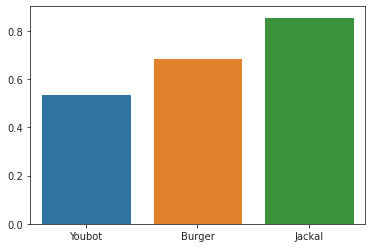

In [6]:
sns.set_style("white")
sns.set_style("ticks")
test = {'Planner':['Youbot', 'Burger', 'Jackal'], 'Collision': [.54, .69, .86]}
g = sns.barplot(data=test, x="Planner", y='Collision',  dodge=False) 
g.figure.savefig('bar-col-prob-planner.svg')

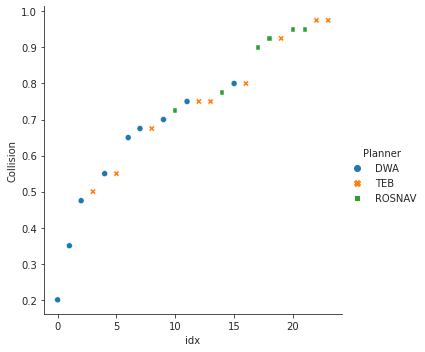

In [57]:
sns.set_style("white")
sns.set_style("ticks")

g = sns.relplot(data=data, x='idx',  y=data.sort_values(by=['Collision'],  ascending=True).Collision, hue="Planner", style="Planner", kind="scatter")
g.savefig('scatter-col-prob.svg')

### Boxplots

In [ ]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Load the example planets dataset

# Plot the orbital period with horizontal boxes
sns.boxplot(x=robot, y=time, whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x=robot, y=time, size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [4]:
performance_predictor_dis = ['success', 'collision']
performance_predictor_cont = ['normalized_curvature', 'roughness', 'path_length', 'angle_over_length', 'jerk', 'vel', 'time']

In [ ]:
# for i in performance_predictor:
#     sns.set_theme(style="ticks")
#     f, ax = plt.subplots(figsize=(7, 6))
#     sns.boxplot(data=data, x='dim', y=i, whis=[0, 100], width=.6, palette="vlag")
#     sns.stripplot(data=data, x='dim', y=i, size=7, color=".3", linewidth=0)
#     ax.xaxis.grid(True)
#     ax.set(ylabel="")

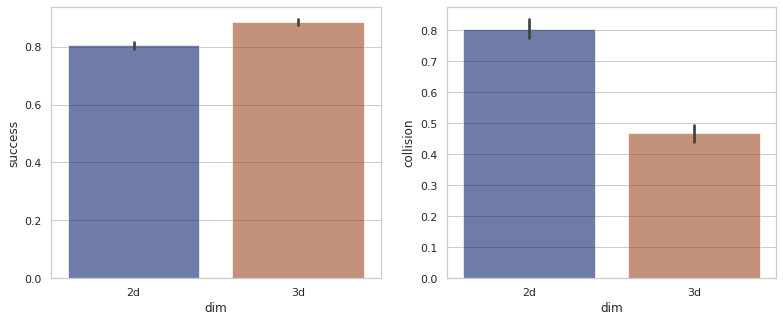

In [8]:
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, ax =plt.subplots(1,2, figsize = (13,5))
for j,i in enumerate(performance_predictor_dis):
    sns.barplot(data=data, x="dim", y=i, ax=ax[j], ci=68, palette="dark", alpha=.6, dodge=False) # in a 68 confidence intervall

# fig.savefig('23_suc_col.svg')

### Bar Plots

In [ ]:
### bar plot
fig, ax =plt.subplots(1,3, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[:3]):
# Draw a nested barplot by species and sex
    sns.barplot(data=data, x="dim", y=i, ax=ax[j], ci="sd", palette="dark", alpha=.6,dodge=False)

fig, ax =plt.subplots(1,3, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[3:]):
# Draw a nested barplot by species and sex
    sns.barplot(data=data, x="dim", y=i, ax=ax[j], ci="sd", palette="dark", alpha=.6,dodge=False)

### Plots Robots

NameError: name 'performance_predictor_cont' is not defined

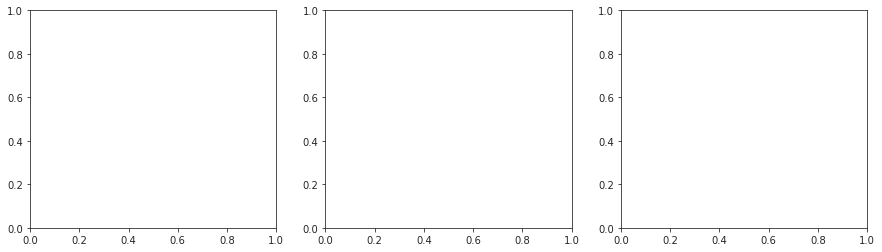

In [43]:
### scatter bar plot
fig, ax =plt.subplots(1,3, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[:3]):
    g =sns.catplot(data=data, x="dim", hue="Robot",y=i, ax=ax[j], kind="bar");

fig, ax =plt.subplots(1,3, figsize = (15,4))
for j,i in enumerate(performance_predictor_cont[:3]):
    # sns.catplot(data=data, x="dim", hue="Robot",y=i, ax=ax[j], kind="point")
    # sns.violinplot(data=data, x='Robot', hue="dim", y=i, ax=ax[j])

    sns.catplot(data=data, x='Robot', y=i, hue="dim", kind="violin", split=True)
    sns.catplot(data=data, x='Robot', y=i, hue="dim", kind="box")


### Plots world

In [23]:
relevant_params = ['time', 'success', 'collision', 'vel', 'path_length']

In [ ]:
sns.set_style("white")
sns.set_style("ticks")

### scatter bar plot
# for i in performance_predictor_cont:
for i in relevant_params:
    # for z in ['time', 'success', 'collision']:
    g = sns.catplot(data=data, x='sys', y=i,kind="bar", palette="deep");
    # g.savefig(f'23_world-{i}-bar.svg')
    # g = sns.catplot(data=data, x='World', y=i, hue='sys', kind="violin", split=True, palette="deep")
    # g.savefig(f'23_world-{i}-vio.svg')

# for i in performance_predictor_dis:
#     g = sns.catplot(data=data, x="Planner", col='World', hue="dim", y=i, kind="bar");
#     g = sns.catplot(data=data, x='Planner', y=i, col='World',  hue="dim",  kind="violin", split=True)
# fig, ax =plt.subplots(1,3, figsize = (15,4))
# for j,i in enumerate(performance_predictor_cont[:3]):
#     sns.catplot(data=data, x="dim", hue="Robot",y=i, ax=ax[j], kind="point")
#     sns.violinplot(data=data, x='Robot', hue="dim", y=i, ax=ax[j])
#     sns.catplot(data=data, x='World', y=i, hue="dim", col="Dyn_obs", kind="violin", split=True)
#     sns.catplot(data=data, x='World', y=i, hue="dim", kind="box")
#     g = sns.catplot(data=data, x='World', y=i, hue="dim", col="Dyn_obs", kind='bar')
#     g = sns.violinplot(data=data, x=i, y="dim", ax=ax[j], bw=.1, cut=4, linewidth=1, inner='quartile')

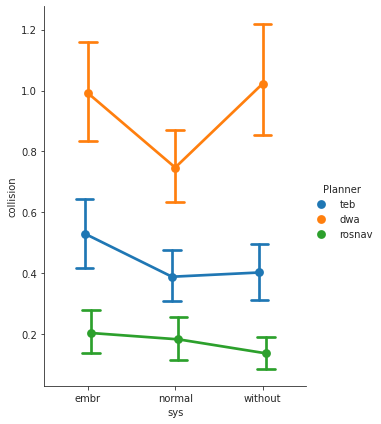

In [138]:
sys = list(data.sys)
sns.set_style("white")
sns.set_style("ticks")
relevant_params = ['time', 'success', 'collision', 'vel', 'path_length']

g = sns.catplot(data=data, x='sys', y='collision', hue="Planner", capsize=.2, height=6, aspect=.75,
                kind="point", dodge=True,)